Text(0.5, 1.0, 'Ground Truth')

<Figure size 640x480 with 0 Axes>

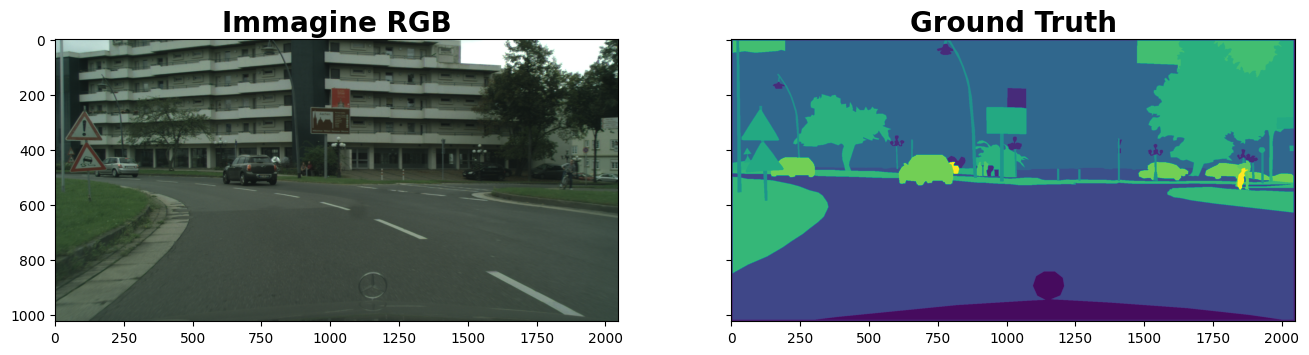

In [1]:
import matplotlib.pyplot as plt
import imageio.v2 as imageio

# Questo è un esempio di un'immagine e la sua label

img = imageio.imread('/kaggle/input/cityscapes/Cityspaces/images/train/aachen/aachen_000000_000019_leftImg8bit.png')
mask = imageio.imread('/kaggle/input/cityscapes/Cityspaces/gtFine/train/aachen/aachen_000000_000019_gtFine_labelIds.png')


plt.figure()
fig, axs = plt.subplots(1,2,sharex=True, sharey=True,figsize=(16,7))
axs[0].imshow(img)
axs[0].set_title('Immagine RGB', fontsize=20, fontweight='bold')
axs[1].imshow(mask)
axs[1].set_title('Ground Truth', fontsize=20, fontweight='bold')

In [2]:
#!pip install torchsummary

In [3]:
#!python -m pip install cityscapesscripts

In [4]:
import os
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms as T
from torchvision.transforms import functional as TF
from torch.utils.data import Dataset, DataLoader
from PIL import Image
#from torchsummary import summary
from tqdm import tqdm
#from cityscapesscripts.helpers.labels import trainId2label as t2l
import cv2
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
class CityscapesDataset(Dataset):
    def __init__(self, image_dir, label_dir):
        self.imagepaths=[]
        self.labelpaths=[]
        self.labelcolorpaths=[]
        self.image_dir=image_dir
        self.label_dir=label_dir

        dir = [os.path.join(image_dir, dir) for dir in sorted(os.listdir(image_dir))]
        for dir1 in sorted(dir):
            self.imagepaths.extend([os.path.join(dir1, dir) for dir in sorted(os.listdir(dir1))]) 

        dir = [os.path.join(label_dir, dir) for dir in sorted(os.listdir(label_dir))]
        for dir1 in dir:
            labelpaths = [os.path.join(dir1, dir) for dir in sorted(os.listdir(dir1))]
            for img in labelpaths:
                if 'labelIds' in os.path.basename(img):
                    self.labelpaths.append(img)

        dir = [os.path.join(label_dir, dir) for dir in sorted(os.listdir(label_dir))]
        for dir1 in dir:
            labelpaths = [os.path.join(dir1, dir) for dir in sorted(os.listdir(dir1))]
            for img in labelpaths:
                if 'color' in os.path.basename(img):
                    self.labelcolorpaths.append(img)              

        
        
    def __len__(self):
        return len(self.imagepaths)

    def __getitem__(self, idx):
                    
        image = imageio.imread(self.imagepaths[idx])
        mask = imageio.imread(self.labelpaths[idx])
        mask_color = imageio.imread(self.labelcolorpaths[idx])
        
        image = cv2.resize(image, (220,110))
        mask = cv2.resize(mask, (220,110))
        mask_color = cv2.resize(mask_color, (220,110))

        img = torch.tensor(image, dtype=torch.float32)
        img = torch.tensor(img.tolist())
        mask = torch.tensor(mask, dtype=torch.int8)
        mask = torch.tensor(mask.tolist())
        img = img.permute(2, 0, 1)
        mask_color = torch.tensor(mask_color, dtype=torch.float32)
        mask_color = torch.tensor(mask_color.tolist())
        mask_color = mask_color.permute(2, 0, 1)
        
        return img, mask, mask_color    

In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels=3, out_channels=64):
        super(DoubleConv, self).__init__()
        self.doubleconv=nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ) 
        
    def forward(self, x):
            return self.doubleconv(x)

In [7]:

class UNet(nn.Module):
    def __init__(self,in_channels = 3,out_classes = 34, features=[64,128,256,512]):
        super(UNet, self).__init__()
        
        self.ups=nn.ModuleList()
        self.downs=nn.ModuleList()
        self.pool=nn.MaxPool2d(kernel_size=2, stride=2)
        
        for feature in features:
            self.downs.append(
                DoubleConv
                    (in_channels,feature))
            in_channels=feature
        
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d
                            (2*feature,feature,kernel_size=2,stride=2)
                           )
            self.ups.append(DoubleConv(feature*2,feature))
            
        self.bootleneck = DoubleConv(features[-1], features[-1]*2)
        
        self.final_conv = nn.Conv2d(features[0],out_classes,kernel_size=1)
        
    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        x = self.bootleneck(x)
        skip_connections = skip_connections[::-1]
        for idx in range(0,len(self.ups),2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:
                x = TF.resize(x,size = skip_connection.shape[2:])
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
        x = self.final_conv(x)

        return x
    

In [8]:
#testing dimension
def test():
    x=torch.randn((1,3,256,256))
    print(x.shape)
    model = UNet(3,34)
    preds = model(x)
    print(preds.shape)
    
test()    

torch.Size([1, 3, 256, 256])
torch.Size([1, 34, 256, 256])


In [9]:
# Definisci il numero di epoche e il learning rate

epochs = 4
learning_rate = 5e-4

# e il dispositivo su cui far girare il codice ('cuda' o 'cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Definire la loss function, che può essere custom o presa dal pacchetto nn
batch_size = 32
model = UNet(3,34)
model = model.to(device)
loss_function = nn.CrossEntropyLoss(ignore_index=255)
loss_function = loss_function.to(device)

# definire l'ottimizzatore
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
# Get train and val dataset instances
train_dir = '/kaggle/input/cityscapes/Cityspaces/images/train'
label_train_dir = '/kaggle/input/cityscapes/Cityspaces/gtFine/train'
val_dir = '/kaggle/input/cityscapes/Cityspaces/images/val'
label_val_dir = '/kaggle/input/cityscapes/Cityspaces/gtFine/val'

train_dataset = CityscapesDataset(image_dir=train_dir, label_dir=label_train_dir)
valid_dataset = CityscapesDataset(image_dir=val_dir, label_dir=label_val_dir)


train_dataset, test_train_dataset = torch.utils.data.random_split(train_dataset, [0.8, 0.2])
valid_dataset, test_valid_dataset = torch.utils.data.random_split(valid_dataset, [0.8, 0.2])

test_dataset = test_train_dataset + test_valid_dataset

#divisione del dataset da aggiustare
#train_dataset.__getitem__(3)    
# Get train and val data loaders
test_loader = DataLoader(test_dataset)
train_loader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_dataset,batch_size=batch_size, shuffle=True)

In [11]:
def jaccard_loss(true, logits, eps=1e-7):
    """Computes the Jaccard loss, a.k.a the IoU loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the jaccard loss so we
    return the negated jaccard loss.
    Args:
        true: a tensor of shape [B, H, W] or [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        eps: added to the denominator for numerical stability.
    Returns:
        jacc_loss: the Jaccard loss.
    """
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1).to(device)[true.squeeze(1).long()]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes).to(device)[true.squeeze(1).long()]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    union = cardinality - intersection
    jacc_loss = (intersection / (union + eps)).mean()
    return jacc_loss

In [12]:
import time
#si deve aggiustare IoU
def train(epochs, model, train_loader, val_loader, loss, optimizer, patch=False):
    train_losses = []
    test_losses = []
    val_loss = []
    val_iou = []
    train_iou = []
    min_loss = np.inf
    
    model.to(device)
    fit_time = time.time()
    
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        
        #training loop
        model.train()
        for data, target, colored in tqdm(train_loader):
            #training phase

            mask= target.squeeze()
            data = data.to(device)
            mask = mask.to(device)
            
            optimizer.zero_grad()
            #forward
            
            output = model(data)
            
            # Loss and IoU evaluation
            loss = loss_function(output, mask)
            iou_score += jaccard_loss(mask, output).item()
            # backward
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        model.eval()
        val_loss = 0
        val_iou_score = 0
        #validation loop
        with torch.no_grad():
            for data, target, colored in tqdm(val_loader):
                output = model(data.to(device))
                mask= target.squeeze()

                mask = mask.to(device)
                
                #Loss and IoU evaluation
                val_iou_score +=  jaccard_loss(mask, output)
                loss = loss_function(output, mask)                          
                val_loss += loss.item()
            
        # Viene salvata la loss ad ogni epoca sia per il training che per il validation
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(val_loss/len(val_loader))

        # Viene salvato il modello solo se la validation loss è migliore degli step precedenti.
        
        if min_loss > (val_loss/len(val_loader)):
            print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (val_loss/len(val_loader))))
            min_loss = (val_loss/len(val_loader))

            print('saving model...')
            torch.save(model.state_dict(), 'UNet_best.pt')


        # Viene salvata la IoU ad ogni epoca sia per il training che per il validation
        val_iou.append(val_iou_score/len(val_loader))
        train_iou.append(iou_score/len(train_loader))

        print("Epoch:{}/{}..".format(e+1, epochs),
              "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
              "Val Loss: {:.3f}..".format(val_loss/len(val_loader)),
              "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
              "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
              "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
              }
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    print('saving model...')
    torch.save(model, 'UNet_last.pt')
    return history

history = train(epochs, model, train_loader, val_loader, loss_function, optimizer)

  0%|          | 0/75 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 13/13 [02:27<00:00, 11.36s/it]


Loss Decreasing.. inf >> 1.293 
saving model...
Epoch:1/4.. Train Loss: 1.884.. Val Loss: 1.293.. Train mIoU:0.047.. Val mIoU: 0.072.. Time: 19.24m


100%|██████████| 13/13 [02:06<00:00,  9.72s/it]


Loss Decreasing.. 1.293 >> 1.065 
saving model...
Epoch:2/4.. Train Loss: 1.064.. Val Loss: 1.065.. Train mIoU:0.095.. Val mIoU: 0.104.. Time: 16.72m


100%|██████████| 13/13 [02:06<00:00,  9.70s/it]


Loss Decreasing.. 1.065 >> 0.883 
saving model...
Epoch:3/4.. Train Loss: 0.851.. Val Loss: 0.883.. Train mIoU:0.127.. Val mIoU: 0.129.. Time: 16.61m


100%|██████████| 13/13 [02:06<00:00,  9.71s/it]


Loss Decreasing.. 0.883 >> 0.767 
saving model...
Epoch:4/4.. Train Loss: 0.744.. Val Loss: 0.767.. Train mIoU:0.152.. Val mIoU: 0.151.. Time: 16.54m
Total time: 69.11 m
saving model...


Test IoU = 0.10858842730522156
Test IoU = 0.09827964007854462
Test IoU = 0.095703125
Test IoU = 0.105514295399189
Test IoU = 0.1028214693069458
Test IoU = 0.0958850085735321
Test IoU = 0.11061485856771469
Test IoU = 0.08992426842451096
Test IoU = 0.10663052648305893
Test IoU = 0.11092019826173782
Test IoU = 0.11181120574474335
Test IoU = 0.11484424024820328
Test IoU = 0.09498748183250427
Test IoU = 0.1158665269613266
Test IoU = 0.08706673234701157
Test IoU = 0.08622750639915466
Test IoU = 0.13376383483409882
Test IoU = 0.08966443687677383
Test IoU = 0.10273313522338867
Test IoU = 0.11050520092248917
Test IoU = 0.11158204823732376
Test IoU = 0.10401616245508194
Test IoU = 0.10161559283733368
Test IoU = 0.11184860020875931
Test IoU = 0.08734410256147385
Test IoU = 0.10941553860902786
Test IoU = 0.09823783487081528
Test IoU = 0.10852015018463135
Test IoU = 0.09506206959486008
Test IoU = 0.09298484027385712
Test IoU = 0.09164242446422577
Test IoU = 0.10714307427406311
Test IoU = 0.11541420

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

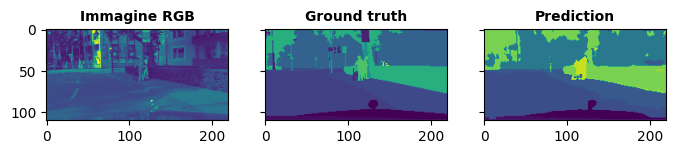

<Figure size 640x480 with 0 Axes>

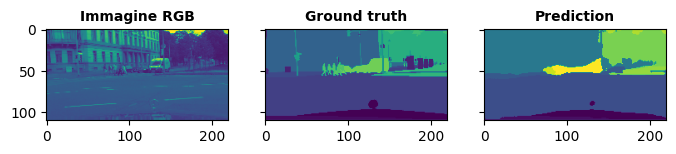

<Figure size 640x480 with 0 Axes>

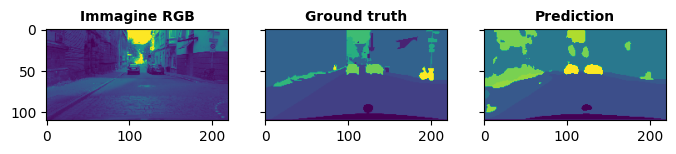

<Figure size 640x480 with 0 Axes>

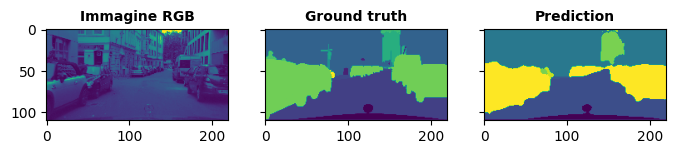

In [15]:
random_idx = random.randint(0, len(test_loader)-1)
image, mask, colored = test_dataset[random_idx]

test_iou_score = 0
model = UNet(3,34)
model.load_state_dict(torch.load('/kaggle/working/UNet_best.pt'))
model.eval()
with torch.no_grad():
    for idx , (data, target, colored) in enumerate(test_loader):

        image = data

        output = model(data)
        
        predictions = torch.nn.functional.softmax(output, dim=1)
        pred_labels = torch.argmax(predictions, dim=1) 
        pred_labels = pred_labels.float()
        pred_labels = pred_labels.squeeze()

        #IoU evaluation
        test_iou = jaccard_loss(target, output)
        
        image = image.squeeze()
        colored = colored.squeeze()
        im = image[2].cpu().numpy()
        mask = target[0].cpu().numpy()
        out = pred_labels.cpu().numpy()
        

        plt.figure()
        fig, axs = plt.subplots(1,3,sharex=True, sharey=True,figsize=(8,3))
        axs[0].imshow(im)
        axs[0].set_title('Immagine RGB', fontsize=10, fontweight='bold')
        axs[1].imshow(mask)
        axs[1].set_title('Ground truth', fontsize=10, fontweight='bold')
        axs[2].imshow(out)
        axs[2].set_title('Prediction', fontsize=10, fontweight='bold')
        
        if idx%5==0:
            plt.close('all')

        
        print(f"Test IoU = {test_iou}")